In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**a) Оценка вероятности, того, что клиент откроет банковский депозит в результате маркетинговой акции**

In [285]:
df = pd.read_csv('/content/gdrive/My Drive/StudyData/bank-full.csv')
#df = df.sample(n=3000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [286]:
X = df.drop(['y'],axis=1)
y = df['y']

In [287]:
y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Нормализация категориальных признаков типа string и всех остальных

In [288]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Сохранить категориальные значения в отдельном датафрейме
categorical_data = df[categorical_columns]

# Сохранить числовые значения в отдельном датафрейме
numerical_data = df[numerical_columns]

# Нормализовать числовые данные
scaler = MinMaxScaler()

# Преобразовать категориальные данные
label_encoder = LabelEncoder()
categorical_data_encoded = categorical_data.apply(label_encoder.fit_transform)

y = label_encoder.fit_transform(y)

# Соединить нормализованные числовые данные с преобразованными категориальными данными
data_normalized = pd.concat([pd.DataFrame(numerical_data, columns=numerical_columns), categorical_data_encoded], axis=1)

X = scaler.fit_transform(data_normalized)

In [289]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.2, 
                                                            random_state = 0)
print(f'Train : {X_train_val.shape}, Test : {X_test.shape}')

Train : (36168, 16), Test : (9043, 16)


In [290]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size = 0.2, random_state = 0)
print(f'Train : {X_train.shape}, Test : {X_val.shape}')

Train : (28934, 16), Test : (7234, 16)


In [291]:
from keras.models import Sequential
from keras.layers import Dense
binary_classifier = Sequential()
binary_classifier.add(Dense(8,activation='relu',input_dim=16))
binary_classifier.add(Dense(1,activation='sigmoid'))

In [292]:
binary_classifier.compile(loss='binary_crossentropy',optimizer='adam',
                          metrics='accuracy')

In [293]:
binary_classifier.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [294]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Temp/y-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                              monitor='val_accuracy',verbose=1,mode='max',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [ ]:
binary_classifier_history = binary_classifier.fit(X_train, y_train, batch_size=10,
                      validation_data=(X_val,y_val), callbacks=callbacks_list, epochs=150)

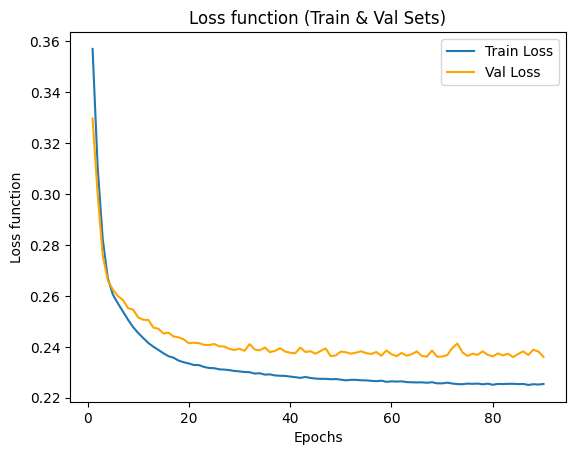

In [296]:
loss_function = binary_classifier_history.history['loss']
val_loss_function = binary_classifier_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()
plt.show()

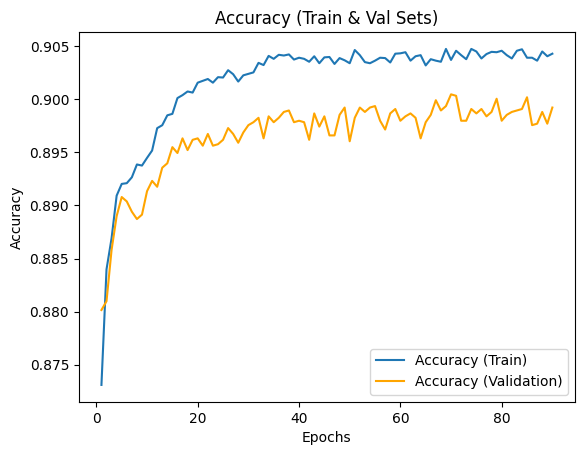

In [297]:
acc = binary_classifier_history.history['accuracy']
val_acc = binary_classifier_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [299]:
results = binary_classifier.evaluate(X_test,y_test)

283/283 [==============================] - 0s 1ms/step - loss: 0.2441 - accuracy: 0.8961


In [302]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

y_pred = binary_classifier.predict(X_test)
y_pred = (y_pred > 0.5)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred = binary_classifier.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC:", auc_score)

283/283 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.59      0.38      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043

[[7701  279]
 [ 661  402]]
283/283 [==============================] - 1s 3ms/step
AUC: 0.8889450814241624


**b) Оценка здоровья внутриутробного развития плода**

In [303]:
df = pd.read_csv('/content/gdrive/My Drive/StudyData/fetal_health.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [304]:
X = df.drop(['fetal_health'],axis=1)
y = df['fetal_health']

In [305]:
y=y-1

In [306]:
y.value_counts()

0.0    1655
1.0     295
2.0     176
Name: fetal_health, dtype: int64

In [307]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [308]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.2, 
                                                            random_state = 0)
print(f'Train : {X_train_val.shape}, Test : {X_test.shape}')

Train : (1700, 21), Test : (426, 21)


In [309]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size = 0.2, random_state = 0)
print(f'Train : {X_train.shape}, Test : {X_val.shape}')

Train : (1360, 21), Test : (340, 21)


In [310]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [311]:
multi_classifier = Sequential()
multi_classifier.add(Dense(8,activation='relu',input_dim=21))
multi_classifier.add(Dense(3,activation='softmax'))

In [312]:
multi_classifier.compile(loss='categorical_crossentropy',optimizer='adam',
                          metrics='accuracy')

In [ ]:
multi_classifier_history = multi_classifier.fit(X_train, y_train, batch_size=10,
                      validation_data=(X_val,y_val), epochs=50)

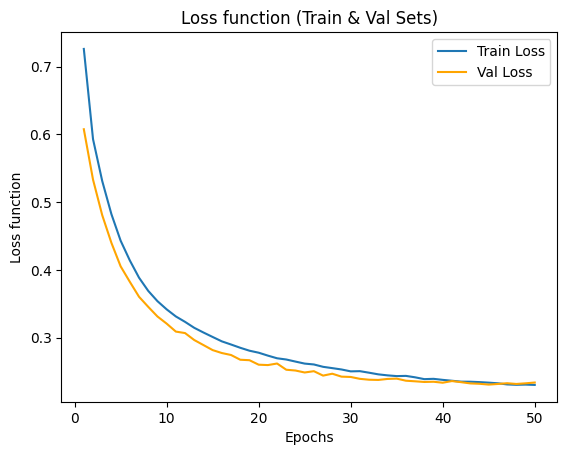

In [314]:
loss_function = multi_classifier_history.history['loss']
val_loss_function = multi_classifier_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()
plt.show()

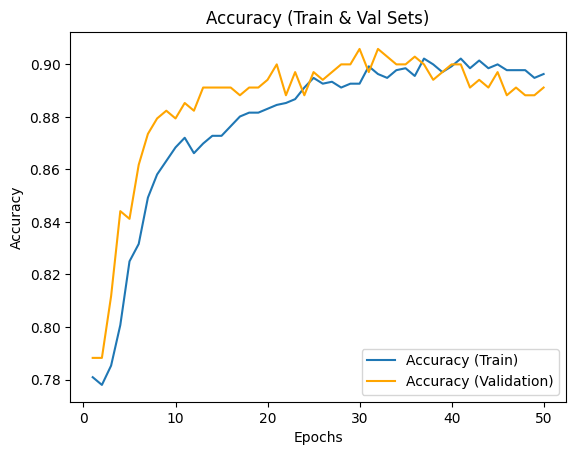

In [315]:
acc = multi_classifier_history.history['accuracy']
val_acc = multi_classifier_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [317]:
results = multi_classifier.evaluate(X_test,y_test)

14/14 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.8826


14/14 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       326
           1       0.63      0.66      0.64        58
           2       0.85      0.79      0.81        42

   micro avg       0.88      0.88      0.88       426
   macro avg       0.80      0.79      0.80       426
weighted avg       0.88      0.88      0.88       426
 samples avg       0.88      0.88      0.88       426



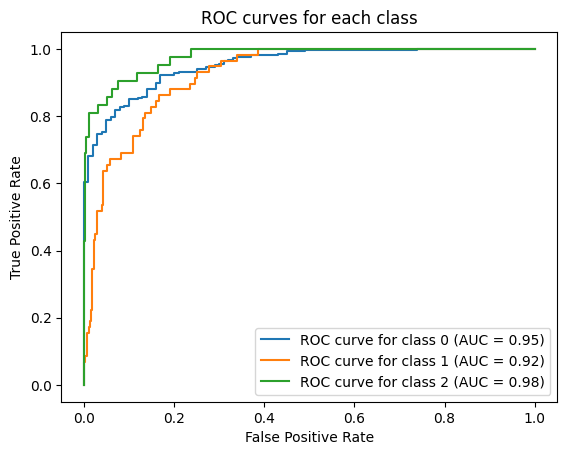

In [324]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

y_pred = multi_classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = multi_classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred_classes, axis=1)
y_pred_classes = to_categorical(y_pred_classes)
print(classification_report(y_test, y_pred_classes))

# Вычисление ROC-кривых для каждого класса и вывод их на график
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='ROC curve for class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each class')
plt.legend()
plt.show()

**c)	Оценка уровня потребления ресурсов домохозяйством**

Загрузка датасета с удалением стобцов в которых смешанный тип данных и текстовый

In [325]:
df = pd.read_csv('/content/gdrive/My Drive/StudyData/DS_2019_public.csv', encoding='cp1251')
df = df.drop(df.columns[[30, 56, 96, 114]], axis=1)
df = df.select_dtypes(exclude=['object'])

<ipython-input-325-ad6eeee721be>:1: DtypeWarning: Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/gdrive/My Drive/StudyData/DS_2019_public.csv', encoding='cp1251')


In [326]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 113 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79)
memory usage: 9.4 MB


In [327]:
df['TOTALBTUCOL'].describe()

count     10875.000000
mean       5741.650943
std        8464.591405
min           0.000000
25%         488.500000
50%        2553.000000
75%        7784.000000
max      208117.000000
Name: TOTALBTUCOL, dtype: float64

In [328]:
X = df.drop(['TOTALBTUCOL'],axis=1)
y = df['TOTALBTUCOL']

In [329]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [330]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.2, 
                                                            random_state = 0)
print(f'Train : {X_train_val.shape}, Test : {X_test.shape}')

Train : (8700, 112), Test : (2175, 112)


In [331]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size = 0.2, random_state = 0)
print(f'Train : {X_train.shape}, Test : {X_val.shape}')

Train : (6960, 112), Test : (1740, 112)


In [332]:
from keras.models import Sequential
from keras.layers import Dense
regressor = Sequential()
regressor.add(Dense(224,activation='relu',input_dim=X_train.shape[1]))
regressor.add(Dense(1))

In [333]:
regressor.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 224)               25312     
                                                                 
 dense_43 (Dense)            (None, 1)                 225       
                                                                 
Total params: 25,537
Trainable params: 25,537
Non-trainable params: 0
_________________________________________________________________


In [334]:
regressor.compile(loss='mse',optimizer='adam',metrics='mae')

In [335]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mse',patience=20,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Temp/concrete_weights-{epoch:02d}-{val_loss:.3f}.hdf5',
                              monitor='val_loss',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [ ]:
regressor_history = regressor.fit(X_train, y_train, batch_size=40,
                      validation_data=(X_val,y_val), callbacks=callbacks_list, epochs=350)

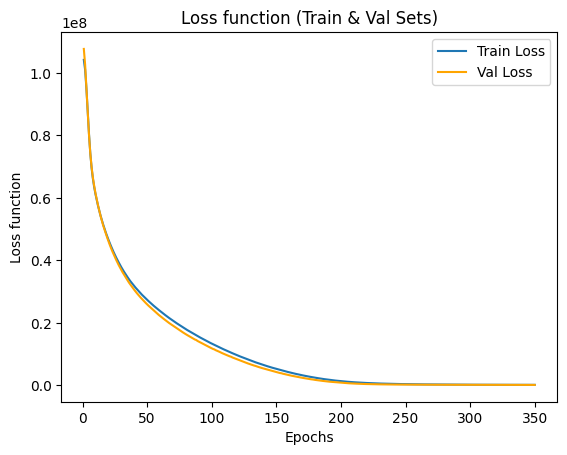

In [337]:
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()
plt.show()

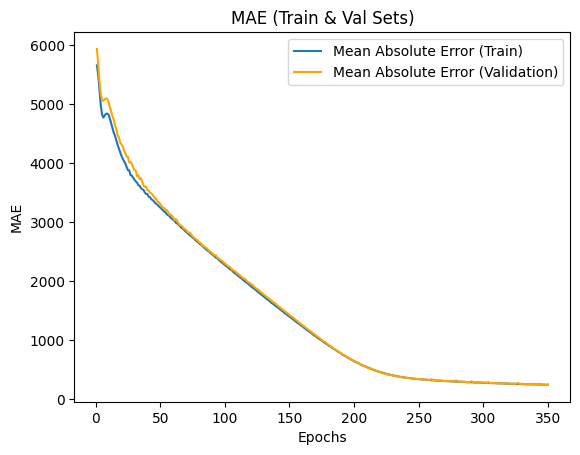

In [338]:
mae = regressor_history.history['mae']
val_mae = regressor_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('MAE (Train & Val Sets)')
plt.plot(epochs,mae,label='Mean Absolute Error (Train)')
plt.plot(epochs,val_mae,color='orange',label='Mean Absolute Error (Validation)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [339]:
results = regressor.evaluate(X_test,y_test)

68/68 [==============================] - 0s 2ms/step - loss: 236155.6250 - mae: 247.3107


In [342]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: {:.2f}".format(mse))
print("MAE: {:.2f}".format(mae))
print("R2: {:.4f}".format(r2))

68/68 [==============================] - 0s 4ms/step
MSE: 236155.54
MAE: 247.31
R2: 0.9965
